## Kaggle Backpack Prediction Challenge

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data_path = os.path.join(os.getcwd(), "backpack_data")
df_train = pd.read_csv(os.path.join(data_path, "train.csv"))
x_train = df_train.drop(columns=["Price", "id"])
y_train = df_train["Price"]
df_test = pd.read_csv(os.path.join(data_path, "test.csv"))

### EDA

In [3]:
# summarytools EDA
from summarytools import dfSummary

dfSummary(df_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 149999.5 (86602.7)min < med < max:0.0 < 149999.5 < 299999.0IQR (CV) : 149999.5 (1.7),"300,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABvklEQVR4nO3XTWrCUBRA4feCFVtFEVEX0B04dBFdbBfhChx00pEzQUKCqaXFpsS5aBKxPXC+ca73Do5/sSzLIP13yV8fIF2jc+mBGONjCKEbmr8RfhrOtp2n7qbe3Xb+qyzLQ6NQq0gnk8nLcDgc1916PB4fiqJ4HgwG70mSfN9znrqbevct5vM8T2OMr+divfSJ2q0iXS6Xh9Fo9Fln8WazGa/X6+lisXibz+dpratbzlN3U+9uO59lWW+1Wo13u131zd0o1JMq0tls9lFneZqm1U+G0O/3a8+2nafupt59i/kQwmn+HP9MCcFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhiqEzjUPZVnWq/vC+/3+NFMURW+73T7dc566m3p3aDl/TV+/kpY55lOonvoAAAAASUVORK5CYII="">",0(0.0%)
2,Brand[object],1. Adidas2. Under Armour3. Nike4. Puma5. Jansport6. nan,"60,077 (20.0%)59,992 (20.0%)57,336 (19.1%)56,814 (18.9%)56,076 (18.7%)9,705 (3.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQ0lEQVR4nO3bMYrbQACGUSmYkDQ2i8GH8SFy2BzCtzGLXewuaRR0h+Qb8LxXuFXzMUZi/nXbtgUK35KngNgoiY2M2Misy7L8XJbl+zLGn23bPgc9m9jhfD7/Oh6Pb8sAz+fzfV3X34Kbw2EP7Xq9fp5Op6/ywY/H48ftdnu73+/7qSq2CRz2nz20y+XyMeD5+184k/CCQEZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERnvrY7/us8RGPJOxDvsFxv1e2YjrPvuz99u69XMZw7VwMquRMhUnGxmDFzIGL2QMXsj4qEtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSsq8hYV5GxQSBjXcUUJ5tTbTLD1lWWVfMZsq6yrJrTyHWVZdVkfNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzZee11lWTWnYesqy6r52CCQsa7i5U82p9qEhqyrLKvmlK+rLKvmNWpdZVk1IR91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYeN3Bi7HLvIYMXoxd5uRaOBmDFzJeEMj4GyVjXUXGuoqMdRUZLwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcS2cjHUVw082Jw/N4MUghWTwYpBCPXgxSOGf81GXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNgYt66yfiJdV1k/8T/YIJCxriLjBYGM2MiIjaXyF28YQ6aueaQkAAAAAElFTkSuQmCC"">","9,705(3.2%)"
3,Material[object],1. Polyester2. Leather3. Nylon4. Canvas5. nan,"79,630 (26.5%)73,416 (24.5%)70,603 (23.5%)68,004 (22.7%)8,347 (2.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACJ0lEQVR4nO3bS0oDQRiF0WoJopMECWQxWYSLdRHZTZBkoOKkpZbg6/af6nMGTu3BRzcV6k7zPDdIuIv8FxAbSWIjZmqtPbbW7lttn/M8vy/9EPzOZr/fP2+326dW2PV6fZ2m6UVwt23TQzsej++73e6jFXS5XB5Op9PT+Xzub1+x3bBN/9NDOxwOb62u/qnnxjkgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERvZWx/9Gk8rqvKz8T2bfjGx3xerfI2nP2O/rbv0c/A7roUTM9mNkuKAQEzlz6hP52DKrqssqsZTcl1lUTWmyuuqsj/F8DMOCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsTGutdV1Z6HwddVFlXjcS2cGOsqYhwQWPVn1OdzUOXWVVZV4yq1rrKqGlvFdVWpn2D4Ow4IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixMY611VVnoOVrKusqsblWjgx1lWs9s3mrTawUoMXY5exlRm8GLuMr9rgpcSJmP/hR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsrG9dVeEZWNG6yrJqbDYIxFhXseibzduFzLrKwonIusrCifS6avFTKWPyoy4xYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2lllXWTgRXVdZOPFfbBCIsa4ixgGBGLHRUr4AUvwON3nEGX8AAAAASUVORK5CYII="">","8,347(2.8%)"
4,Size[object],1. Medium2. Large3. Small4. nan,"101,906 (34.0%)98,643 (32.9%)92,856 (31.0%)6,595 (2.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB4UlEQVR4nO3bUUoCURiG4TMhUTdKCC7GRbTYFuFuJPQio5uJA3bhAvyc8/c8UNBVCi+jM5xvmue5QcJT5L+A2EiaWmuvrbXnVsvPPM+XR78Ibq222+37er1+a4Wcz+fPaZo+BLcsqx7afr+/bDab71bA6XR6ORwOb8fjsV+txbYgq/6rh7bb7b5aHf2rAQvjBoEYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYyJ766MdyWhGV3ks1q37QsJ//qnQsp7+nflr30a+DW46FEzOZ8pHiBoGYah+jPj4XrNS6yqpq2cqsq6yqlq/auqrM45uK3CAQIzZixEaM2IgRGz

In [4]:
# ydata_profiling EDA - mainly for correlation matrix
from ydata_profiling import ProfileReport

profile = ProfileReport(
    df_train,
    samples=None,
    # correlations=None,
    missing_diagrams=None,
    duplicates=None,
    interactions=None,
)
profile.to_widgets()

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Missing values
print()
row_missing_count = df_train.isna().sum(axis=1)
row_missing_prop = row_missing_count.value_counts() / len(df_train)
print("Number of missing values by row:\n" + str(row_missing_prop))
col_missing_prop = df_train.isna().sum() / len(df_train)
print("\nProportion of missing values by column:\n" + str(col_missing_prop))


Number of missing values by row:
0    0.822287
1    0.165853
2    0.010877
3    0.000877
4    0.000107
Name: count, dtype: float64

Proportion of missing values by column:
id                      0.000000
Brand                   0.032350
Material                0.027823
Size                    0.021983
Compartments            0.000000
Laptop Compartment      0.024813
Waterproof              0.023500
Style                   0.026567
Color                   0.033167
Weight Capacity (kg)    0.000460
Price                   0.000000
dtype: float64


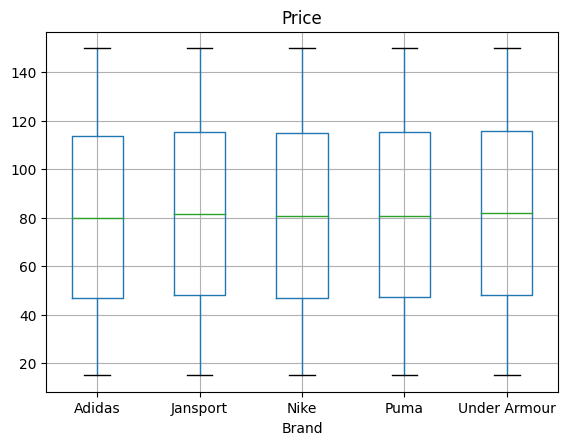

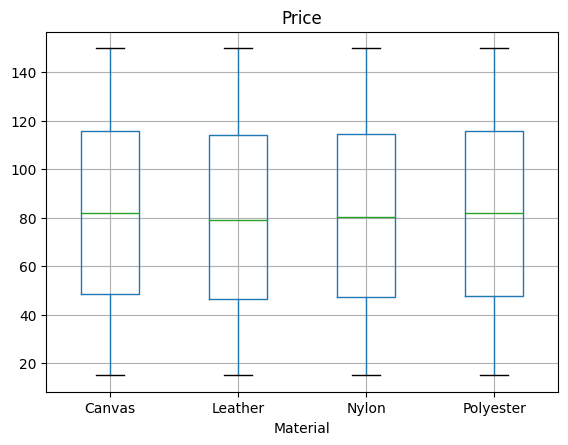

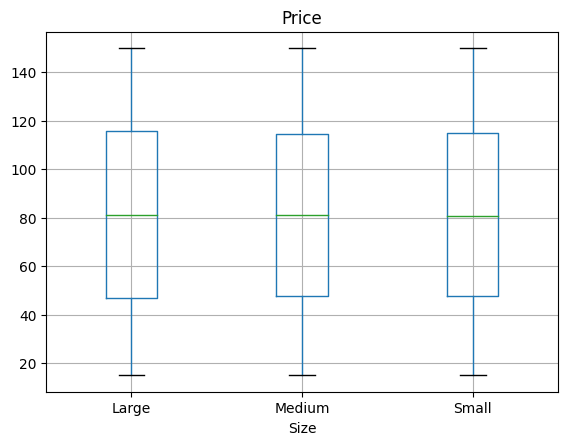

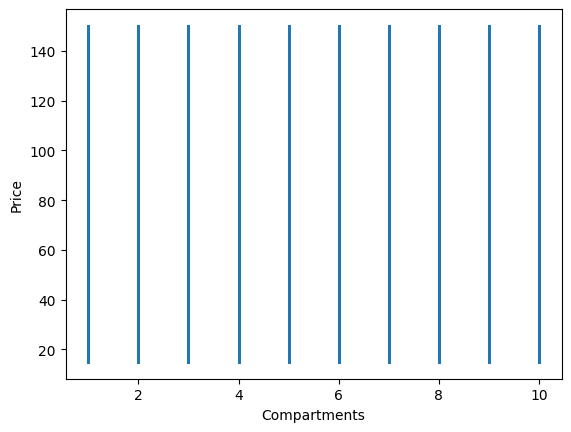

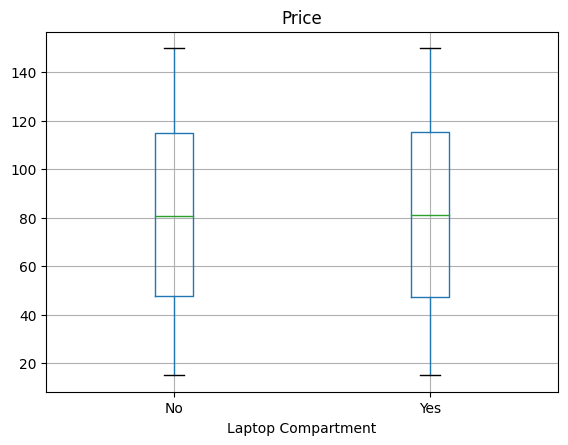

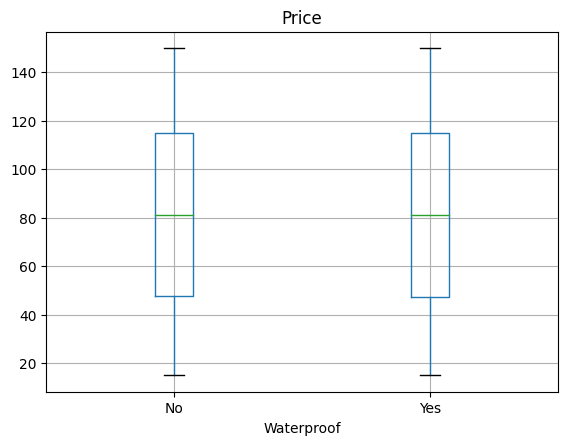

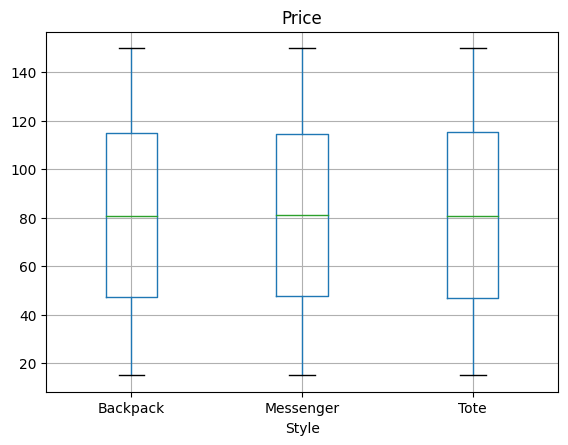

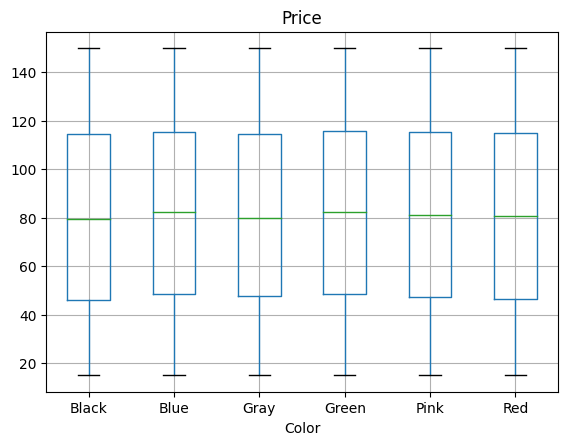

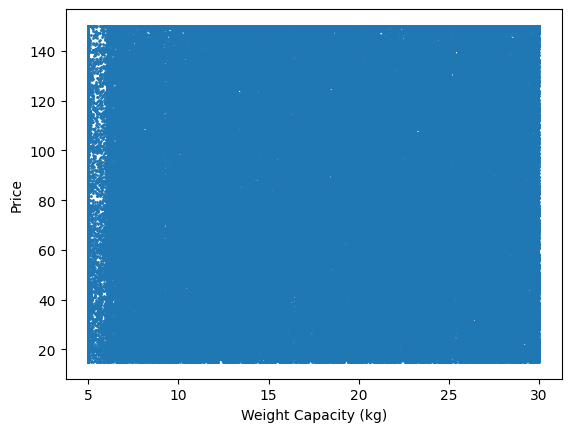

In [6]:
# 2D analysis
for col in x_train.columns:
    # Skip ID
    if col == "id":
        continue
    # Numerical features (Numerical x Numerical)
    if np.issubdtype(df_train[col].dtype, np.number):
        df_train.plot.scatter(x=col, y='Price', s=1)
    # Categorical features (Categorical x Numerical)
    else:
        df_train.boxplot(column='Price', by=col)
    plt.suptitle('')
    # Categorical x Categorical
        #ct = pd.crosstab(df_train['Brand'], df_train[col])
        #display(ct.style.background_gradient(cmap="Blues"))

**EDA Results**
- ID - `id`
    - 300,000 values
- Y/Target - `Price`
    - Ranging from \$15 to \$150, median≈mean≈\$81\
    *Insight: Regression task (e.g. linear regression, KNN regression, decision trees)*
- X - Features
    - Categorical - 5
        - `Brand`, `Material`, `Size`, `Style`, `Color`
            - Low distinct value counts\
            *Insight: Feasible to one-hot encode (4)*
            - Only `Size` is ordinal\
            *Insight: Can ordinal encode (1)*
    - Numerical - 2
        - `Compartments`, `Weight Capacity (kg)`
            - Largely uniformly distributed
            - Largely different scales\
            *Insight: Normalization required (2)*
    - Boolean - 2
        - `Laptop Compartment`, `Waterproof`\
            *Insight: One-hot encoding (4+2=6)*
- Missing Values - 2-3% accross all categorical features (as `nan`), 0.04% missing value from `Weight Capacity (kg)` as `np.nan`\
*Insight: Need to impute (8)*
- Correlation - Price has highest correlation with Weight Capacity at 0.017. Other features are around 0.01-0.017\
*Insight: No single feature has a big effect on price (0.017 is very low). Perhaps a combination of features is required to determine price*
- Duplicate Rows - None

### Feature Engineering

In [ ]:
# Create pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import MinMaxScaler


# Helper function to prefix column names after transformation
def prefixed_columns(prefixes, columns):
    arr = []
    for col in columns:
        prefix = ""
        for pre in prefixes:
            prefix += pre + "__"
        arr.append(prefix + col)
    return arr


# Imputation
imp = ColumnTransformer(
    [
        (
            "cat_imputer",
            SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
            [
                "Brand",
                "Material",
                "Size",
                "Style",
                "Color",
                "Laptop Compartment",
                "Waterproof",
            ],
        ),
        (
            "num_imputer",
            SimpleImputer(missing_values=np.nan, strategy="mean"),
            ["Weight Capacity (kg)"],
        ),
    ],
    remainder="passthrough",
)

# Encoding
enc = ColumnTransformer(
    [
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[["Small", "Medium", "Large"]]),
            prefixed_columns(["cat_imputer"], ["Size"]),
        ),
        (
            "onehot_encode",
            OneHotEncoder(sparse_output=False, drop="first"),
            prefixed_columns(
                ["cat_imputer"],
                [
                    "Laptop Compartment",
                    "Waterproof",
                ],
            ),
        ),
        (
            "target_encode",
            TargetEncoder(),
            prefixed_columns(
                ["cat_imputer"],
                [
                    "Brand",
                    "Material",
                    "Style",
                    "Color",
                ],
            ),
        ),
    ],
    remainder="passthrough",
)

# Scale
scale = ColumnTransformer(
    [
        (
            "scale",
            MinMaxScaler(),
            prefixed_columns(
                ["ordinal_encode", "cat_imputer"],
                ["Size"],
            )
            + prefixed_columns(
                ["onehot_encode", "cat_imputer"],
                [
                    "Laptop Compartment_Yes",
                    "Waterproof_Yes",
                ],
            )
            + prefixed_columns(
                ["target_encode", "cat_imputer"],
                [
                    "Brand",
                    "Material",
                    "Style",
                    "Color",
                ],
            )
            + prefixed_columns(
                ["remainder", "num_imputer"],
                ["Weight Capacity (kg)"],
            )
            + prefixed_columns(
                ["remainder", "remainder"],
                ["Compartments"],
            ),
        ),
    ],
    remainder="passthrough",
)

# Pipeline
pipe = make_pipeline(imp, enc, scale)
pipe.set_output(transform="pandas")

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Brand', 'Material', 'Size',
                                                   'Style', 'Color',
                                                   'Laptop Compartment',
                                                   'Waterproof']),
                                                 ('num_imputer',
                                                  SimpleImputer(),
                                                  ['Weight Capacity (kg)'])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough'...
                                                  ['ordinal_encode__cat_imputer__Size',
                                                   'onehot_encode__cat_imputer__Laptop '
                                                   'Compartment_Yes',
                                                   'onehot_encode__cat_imputer__Waterproof_Yes',
                                                   'target_encode__cat_imputer__Brand',
                                                   'target_encode__cat_imputer__Material',
                                                   'target_encode__cat_imputer__Style',
                                                   'target_encode__cat_imputer__Color',
                                                   'remainder__num_imputer__Weight '
                                                   'Capacity (kg)',
                                                   'remainder__remainder__Compartments'])]))])

In [8]:
# Fit and transform
pipe.fit(x_train, y_train)  # Calls TargetEncoder's fit_transform methdd (cross-fitting)
x_train = pipe.transform(x_train)
dfSummary(x_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,scale__ordinal_encode__cat_imputer__Size[float64],1. 0.52. 1.03. 0.0,"108,501 (36.2%)98,643 (32.9%)92,856 (31.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABgklEQVR4nO3bQUrDUBSF4RspopMWKXQxXYSLdRHdTZF2oOIk8jZxmnf9voFTE/hJm/LOsq5rQcJT5L9AVS1V9VpVz9XX77qu34++CKp2x+Pxfb/fv1VT9/v9c1mWD8E93m6Edj6fvw+Hw081c7vdXi6Xy9v1eh1PbrE92G78GaGdTqev6ml8TWADvCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI3vEaJz7qoa63tesduMk6zhg2PXc17i/cTT80deBDQJBiykfKd2ebJ5iG9ZqXWVJtW1t1lWWVNvXbV3V8o26Cz/qEiM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiOmzbqqwz1012pdZUm1bTYIxFhXEeMFgZgOH6M+Oicx/ZTPfG8eU0/5zPfm0mHKN/1PNv+FFwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxEw95Zv1uv+r6ad85nvzsEEgxpSPSvkDSryjSk/7jAwAAAAASUVORK5CYII="">",0(0.0%)
2,scale__onehot_encode__cat_imputer__Laptop Compartment_Yes[float64],1. 1.02. 0.0,"155,786 (51.9%)144,214 (48.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bTUrDUACF0RcJopOGUuhiuggX6yK6myDpwIqTyJs5EJr0yS0t5wwcBRrCR3/k3W6e5wIJXSnltZTyHHm1x/Q9z/P51jdxD/rdbve22Wy2t76Re3U6nT66rnsX3GV9De1wOJyHYfhacD2/TNP0cjwet+M41k8GsV3Q1z81tP1+/3npYv5Uv4awwNOSi+A/iI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb2fNs9RBg7iUfh+e2Tl+PNdfTpg4BXqc+v7pDuPV93AODl3YGLwt1pnykeGdbx7tYA1O+Fcz22pjyLWS2186Ubx2/2Bv4py4xYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjCnfQp5RO1O+Fcz22hi8rGPwUq73Awpbat/J3dT/AAAAAElFTkSuQmCC"">",0(0.0%)
3,scale__onehot_encode__cat_imputer__Waterproof_Yes[float64],1. 1.02. 0.0,"155,127 (51.7%)144,873 (48.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bTUrDUACF0RcJopOGUuhiuggX6yK6myDpwIqTyJs5EJr0yS0t5wwcBRrCR3/k3W6e5wIJXSnltZTyHHm1x/Q9z/P51jdxD/rdbve22Wy2t76Re3U6nT66rnsX3GV9De1wOJyHYfhacD2/TNP0cjwet+M41k8GsV3Q1z81tP1+/3npYv5Uv4awwNOSi+A/iI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEb2fNs9RBg7iUfh+e2Tl+PNdfTpg4BXqc+v7pDuPV93AODl3YGLwt1pnykeGdbx7tYA1O+Fcz22pjyLWS2186Ubx2/2Bv4py4xYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjCnfQp5RO1O+Fcz22hi8rGPwUq73Awpbat/J3dT/AAAAAElFTkSuQmCC"">",0(0.0%)
4,scale__target_encode__cat_imputer__Brand[float64],1. 0.083381866140378242. 0.92737171502218273. 0.50455212589193374. 0.58781444829395475. 0.8083088043999709,"69,782 (23.3%)59,992 (20.0%)57,336 (19.1%)56,814 (18.9%)56,076 (18.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACE0lEQVR4nO3bQWrbQACGUbmY0m5sgsGHySF62B7CtzHFXjSlGxfdIf1GaN5bZBstPiTGzH94vV4LFL4k/wXERklsZA7LsnxfluXrsh1/X6/Xx+iH4PMdL5fLj9Pp9LZsxPP5/HU4HH4Kbn+Oa2jv7+8f5/P5z+iHeTwe326329v9fl/ftGLbmeP6Zw3ter3+XrZh/ayzQw4IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZstLc+1qs9ywZs5Tn4P47rZcX1DtlWrvasz7Pe1h39HHw+18LJHOxGqTggMM1n1CdzIkPXVZZUcxm2rrKkms/oddUmfm6h4YBARmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMTG/tdVllTzGbqusqSai2vhZKyryDggMMVn1Cd0MsPWVZZV8xmyrrKsmtPIdZVl1WQcEMiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Nj3usqyak7D1lWWVfNxLZyMdRW7f7N5q01oyODF2GVO+eDF2GVeowYvxi4T8qMuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGx33WVZdW8hqyrLKvmZINAxrqKjDcbGesqMtZVZKyryPhRl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuImODQMa6iowDAhmxsVT+AccxDjfM3ig0AAAAAElFTkSuQmCC"">",0(0.0%)
5,scale__target_encode__cat_imputer__Material[float64],1. 0.87980946637416932. 0.055262768306583613. 0.36587969339382914. 0.9384190013315816,"87,977 (29.3%)73,416 (24.5%)70,603 (23.5%)68,004 (22.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIH

**FE Results**
- 7 categorical features imputed by mode
- 1 numerical feature imputed by mean
- 1 categorical feature ordinal encoded
    - Note: Average price for the following bag types - Messenger (81.45), Tote (81.37), Backpack (81.40). Considered ordinal encoding by general size of the bag types, but the size difference isn't very defined and it doesn't make  much sense considering the data
- 2 categorical (boolean) features one-hot encoded (drop first to prevent multicollinearity)
- 4 categorical features target encoded
- 9 numerical (after encoding) features min-max scaled (normalised)
- Note: Doing PCA doesn't seem to help much, each variable adds a similar amount of variance (cumulative_variance = [0.20786762 0.40454002 0.53375662 0.63395941 0.71753398 0.79765314
 0.87016806 0.93712852 1.        ])

### Modelling

In [9]:
# Train-test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=111
)

In [10]:
# Model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

lr = LinearRegression().fit(x_train, y_train)
lr_pred = lr.predict(x_test)

knr = KNeighborsRegressor().fit(x_train, y_train)
knr_pred = knr.predict(x_test)

dtr = DecisionTreeRegressor().fit(x_train, y_train)
dtr_pred = dtr.predict(x_test)

### Evaluation

In [11]:
# Score - Kaggle metric is RMSE
from sklearn.metrics import root_mean_squared_error

print("LR Error: " + str(root_mean_squared_error(y_test, lr_pred)))
print("KNR Error: " + str(root_mean_squared_error(y_test, knr_pred)))
print("DTR Error: " + str(root_mean_squared_error(y_test, dtr_pred)))

# Other metrics
print("Nodes on DTR: " + str(dtr.tree_.node_count))

# Show shape of predictions
predictions = pd.DataFrame(
    {"Price (LR)": lr_pred, "Price (KNR)": knr_pred, "Price (DTR)": dtr_pred}
)
dfSummary(predictions)

LR Error: 39.04725126249492
KNR Error: 42.73619147691974
DTR Error: 55.85141093313666
Nodes on DTR: 479171


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Price (LR)[float64],Mean (sd) : 81.4 (1.3)min < med < max:77.3 < 81.4 < 85.2IQR (CV) : 1.8 (62.8),"59,992 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACiUlEQVR4nO3du47aQBiG4ZnAbhyIOAgJOlqKSCkouYhcbC4hBUVKxB3QIQ4C4YW1MY6cKomiZH3anW94n2ab9a6LV8iD7X9smqYGcN27tz4B4CWaL/ot5GKt/WCMeSx4eJSm6bniU5JHqDVEOhgMvnQ6nX6R44/H495a+5VYf0eo1XvMIp3NZudut3vJc+DhcAjm83l/u91mn8aE+gtCrUkW6XA4fCpwaHbZgD8QavXXmZ3b7fZQwyndNUKt+DozjuMgSZJPl8vlmzGmyCcq/oJQK77OXK1W/eVy2bper436Tu/+EGrF15n7/Z5rzBrwhT8kECokECokECokECokECok8PWUY5Ikye5qday1Rf9E5OMDLYTqkDAMH+I4/jwejxuNRiPXjQbfn74iVIdEUdQMgqA1nU4vo9Fon/f4g8dPXxGqg9rtdtEnrzJe3hljMQUJhAoJhAoJhAoJhAoJhAoJhAoJ3n6PWnIIBC/oOcbLUMsOgeAFPfd4GWqZl/MyvKDnHl9DLTUEghf03MNiChIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRK8vjN1j5JycwGcnQlAqB4JS84FcHkmAKF6JCoxF8D1mQCE6qF28bkAzj6Mw2IKEggVEggVEggVEggVEpxe9bPNI5wPlW0eIREq2zxCJdSf2OYRGRZTkECokECokECokECokOD8qh+vx+VdAwkVErsGEiokdg0kVEjsGshiChJq/URljj6cD5U5+lD5RGWOPnQWU8zRRxVY9UNinNB/Q+V1ELgwTqhZ9+sgm83muyngdDoF2c8wDIP1et16rWPf8n+rnrcxxux2u4/ZDYPJZGJ7vd5znmPP5/P7xWLxz5sFPwDoo4coFCG/KwAAAABJRU5ErkJggg=="">",0(0.0%)
2,Price (KNR)[float64],Mean (sd) : 81.3 (17.4)min < med < max:20.6 < 81.2 < 142.4IQR (CV) : 24.1 (4.7),"57,923 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACjUlEQVR4nO3dQW7aQBiG4ZnipC5IIEQEOy5QqQuWHKKH7RGKxAm4ATskC4FwQ22MK1dZVBVpYxvH843fZx0HL14mQJh/bJ7nBnDdh7ZvAHiL4E0/1UHW2k/GmMeKlyd5nj/f+ZY6jVBfiXQymXwdDofjKtcfj8e9tfYbsd4Pod72WES6XC6fR6PRucyFh8MhXK1W0yiKnqy1xwqPzWp8A6H+QxHpdDr9UeaaOI4f0jT9Mp/Pe71er1TkBVbj2wj1zpIkCcIw7C8Wi/NsNtuXXY3X6/U4iqLitTGh/oFQGzIYDEqvxi+KN3H4Cx9PQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQoK33/Cvud15eL1eH+58S6jBy1DrbndO0zTMsuzz+Xz+boypsp0Ed+ZlqHW2Oxe22+14s9n0L5dLz7yzLMuKlXxora36KxIfd7D6Gmrl7c6F/X7fyga7ulutfd5u7XWoXdpq7ft2a0L1a6u1t9ut+XgKEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEgJPp50w6cQzgY/TTro86SSrN8DC2eEVgY/TTtqcdNKmuOYAC5eHV7gcauVpJ21NOlEeYHFwfHiF86GivBoDLJx9gvOuHxIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIa/c8UZz1pyRw+kaWxUDnrSUvs+IksTa6osmc9dVHi+IksjX8pRe2sp64bOHoiy39DtdaGxpiPFV9jBsUzrcqNnU6n39fFcRzudrv+e13b5mOr3rd5WVGzLCt6qvoa92ee56/+5f0FbTBrfz8HH6oAAAAASUVORK5CYII="">",0(0.0%)
3,Price (DTR)[float64],Mean (sd) : 81.4 (40.0)min < med < max:15.0 < 80.7 < 150.0IQR (CV) : 70.4 (2.0),"30,705 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/OQEPoAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACy0lEQVR4nO3Zv2/aQByG8TsgwQFqK4HCxtIxUgckFpZuHfvHdu0WpETqzNClEwtCQvwQbhDGUDkqc/A5Dn7p85mxg6wn3zsf9nA4GKDoSuf+AsApKq99wFp7Y4y5Nm62h8Ph2fFa4LRQk0ibzeY33/dvjYPVajW31n4nVuQ9Ua+TSAeDwXMQBJs0N14ul97j4+PtbDZLpjGhIt+lP5FE2m63/zjcP9k2AJnxMgUJhIrLWfpdxXF8ZYzxrbWut+DUAPmGGobhVRRFn7vdbrlcLqd6ETtaLBZra+0PY4zL9USeUsajyFyfeW6hbrfbiud5tV6vt+l0OvO0108mkw9PT09fut1uyyV0jsbSyXoUmfczz3XpT9TrdacTg/l8fuMa+v98NGbdp6LfaDTag8FglfYo8vjMh8Nhezabtay1q7eexrmHeq7Qsx6NKf4iZzNMxSiKvDiO76vV6oPL88661XttGhc+1DO9yHl3d3dfgyCou1x8xm3HtesPNOPx+HY0GtV2u135vbd6p6yAFxlq1v/uZLoYY+77/f7PVqu1Utt2BA4/0CRbrSKvgBcZatYXueN08TwvcnnocRz7GaZ5cra9d7nQGOPv9/tkJbk4FxnqW7zInWOaJ9uVMAw/NRqN36VSKXLdZ242mwdjjMtUK6yLDlVtmv+b5B97vd6vLCvBznGfWWSEWqBpfpzk51gJio7f+iGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGhcsqHlsull/bG6/X65ZowDL3pdFp7z+tV/7bq9zYZrz+lr7/GTIqkI6DGBQAAAABJRU5ErkJggg=="">",0(0.0%)


**Modelling Results**
- LR Model seems to make conservative predictions, which are all around the average (likely underfitting)
- DTR seems to make much more outlandish predictions, uniformly distributed accross the min and max (likely overfitting). Very high number of nodes as well. Although, it is the only model which predicts with a uniform distribution.
- KNR is somewhere in the middle (but still not very accurate)
- Predicting the average price from the training set gives error: 39.0659
- Best model - LR with error 39.0493
___
After further feature engineering:
- Best model - LR with error 39.0473

### Submission

In [12]:
# Predict
id = df_test["id"]
df_test = pipe.transform(df_test)
df_test["Price"] = lr.predict(df_test)

In [13]:
# Zip with IDs and save to CSV
sub = pd.concat([id, df_test["Price"]], axis=1)
sub.to_csv("submission.csv", index=False)

In [14]:
# Submission with average price values from training set (for comparison)
train_average = pd.Series(np.full((200000,), df_train["Price"].mean()), name="Price")
average_sub = pd.concat([id, train_average], axis=1)
average_sub.to_csv("average_submission.csv", index=False)
print(
    "Average Error: "
    + str(
        root_mean_squared_error(
            y_test, pd.Series(np.full((60000,), df_train["Price"].mean()))
        )
    )
)

Average Error: 39.065902326631125
